In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
os.getcwd()
os.chdir("/home/mbilkis/Desktop/qmon-sindy")
from numerics.utilities.misc import *
import matplotlib.pyplot as plt 



In [3]:

params, exp_path = give_params()

gamma, omega, n, eta, kappa, b, [periods, ppp] = params
period = (2*np.pi/omega)
total_time = period*periods
dt = period/ppp
times = np.arange(0,total_time+dt,dt)


In [4]:
params

[0.3, 10.0, 10.0, 1.0, 20.0, [0.0, 0.1], [10.0, 500]]

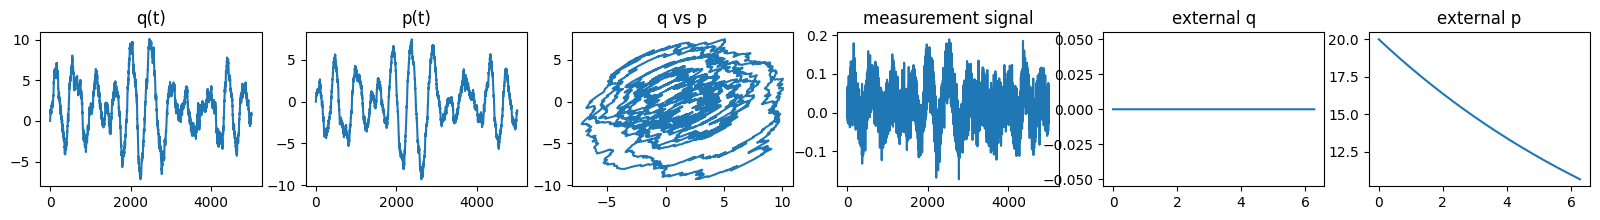

In [21]:
x = load_data(itraj=1, what="hidden_state.npy")
dy = load_data(itraj=1,what="dys.npy")
f = load_data(itraj=1, what="external_signal.npy")

params, exp_path = give_params()

####
gamma, omega, n, eta, kappa, b, [periods, ppp] = params
period = (2*np.pi/omega)
total_time = period*periods
dt = period/ppp

times = np.arange(0,total_time+dt,dt)
if len(times)> int(1e8):
    times = np.linspace(times[0],times[-1],int(1e4))
    
plt.figure(figsize=(20,2))
ax=plt.subplot(161)
ax.plot(x[:,0])
ax.set_title("q(t)")
ax=plt.subplot(162)
ax.plot(x[:,1])
ax.set_title("p(t)")

ax=plt.subplot(163)
ax.plot(x[:,0],x[:,1])
ax.set_title("q vs p")
ax=plt.subplot(164)
ax.plot(dy[:,0])
ax.set_title("measurement signal")
ax=plt.subplot(165)
ax.plot(times,f[:,0])
ax.set_title("external q")

ax=plt.subplot(166)
ax.set_title("external p")
ax.plot(times,f[:,1])

In [22]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.linalg import solve_continuous_are


Question 2 talk w/ giulio; f should be (0,f) right ? to be a force... so we put some dynamics in one component only? Maybe it's easier but also more boring ...?

In [23]:
class GRNN(torch.nn.Module):
    def __init__(self,inputs_cell):
        super(GRNN, self).__init__()
        
        self.dt, self.simulation_params, initial_force_params = inputs_cell
        gamma, omega, n, eta, kappa, b = self.simulation_params 
        
        self.damping_force = torch.nn.Parameter(data = torch.tensor(initial_force_params[0],dtype=torch.float32,
                                                              requires_grad=True))
        
        #self.amplitude_force = torch.nn.Parameter(data = torch.tensor(initial_force_params[1],dtype=torch.float32,
        #                                              requires_grad=False))
        
        self.amplitude_force = torch.tensor(initial_force_params[1],dtype=torch.float32)
        
        self.A = torch.tensor(data=[[-gamma/2, omega],[-omega,-gamma/2]], dtype=torch.float32).detach()
        self.proj_C = torch.tensor(data=[[1.,0.],[0.,0.]], dtype=torch.float32).detach()
        self.C = np.sqrt(4*eta*kappa)*self.proj_C.detach()
        self.D = (gamma*(n+0.5) + kappa)*torch.eye(2).detach()

        
        
    def forward(self, dy, state):
        """
        input_data is dy
        hidden_state is x: (<q>, <p>, Var[x], Var[p], Cov(q,q)})
        output dy_hat
        """
        x = state[:2]
        [vx,vp,cxp] = state[2:5]
        f = state[5:-1]
        t = state[-1]
        cov = torch.tensor(data = [[vx,cxp],[cxp,vp]], dtype=torch.float32)
        
        xicov = cov.matmul(self.C.T)
        
        dx = (self.A - xicov.matmul(self.C)).matmul(x)*dt + xicov.matmul(dy)
        
        ### signal part 
        #### g0(f) = f, g1(f) = f**3<
        #dictionary = torch.concatenate([f, f**2, f**3, f**4])
       # 
        #df = self.coeffs_f.dot(dictionary) ###Check this!
        #fnew = f+ df
        fnew = torch.exp(-self.damping_force*(t+dt))*self.amplitude_force
        
        dx += fnew*dt
        
        dcov = self.dt*(cov.matmul(self.A.T) + (self.A).matmul(cov) + self.D - (xicov.matmul(xicov.T)))
        ncov = cov+dcov
        

        nstate = torch.concatenate([(x + dx), torch.tensor([ncov[0,0],ncov[1,1],ncov[1,0]]), fnew, torch.tensor([t+self.dt])])

        dy_hat = self.C.matmul(x)*self.dt

        return nstate, dy_hat

class RecurrentNetwork(torch.nn.Module):
    def __init__(self,inputs_cell):
        super(RecurrentNetwork, self).__init__()
        self.RCell = GRNN(inputs_cell=inputs_cell)
        self.params = inputs_cell[1]
        self.initial_amplitude = inputs_cell[2][1]
        
    def forward(self, dys):
        dys_hat = []
        
        ### Find stationary value of covariance for the parameter RCell currently has
        gamma, omega, n, eta, kappa, b = self.params 
        A = np.array([[-gamma/2, omega],[-omega, -gamma/2]])
        proj_C = np.array([[1.,0.],[0.,0.]])
        C = np.sqrt(4*eta*kappa)*proj_C
        D = np.diag([gamma*(n+0.5) + kappa]*2)
        G = np.zeros((2,2))
        Cov = solve_continuous_are((A-G.dot(C)).T, C.T, D- (G.T).dot(G), np.eye(2)) #### A.T because the way it's implemented!
        t0=0.
        f0x,f0y = self.initial_amplitude 
        xs_hat = [torch.tensor([0., 0., Cov[0,0], Cov[1,1],Cov[1,0], f0x, f0y, t0], dtype=torch.float32)]
        x_hat = xs_hat[0]
        for dy_t in dys:
            x_hat, dy_hat = self.RCell(dy_t, x_hat)
            dys_hat += [dy_hat]
            xs_hat += [x_hat]
        return torch.stack(xs_hat), torch.stack(dys_hat)

In [24]:
x = load_data(itraj=1, what="hidden_state.npy")
dy = load_data(itraj=1,what="dys.npy")
f = load_data(itraj=1, what="external_signal.npy")

params, exp_path = give_params()

####
gamma, omega, n, eta, kappa, b, [periods, ppp] = params
period = (2*np.pi/omega)
total_time = period*periods
dt = period/ppp

times = np.arange(0,total_time+dt,dt)

In [37]:
inputs_cell = [dt,  [gamma, omega, n, eta, kappa, b], [10.,[0., 20.]]]

x = load_data(itraj=1, what="hidden_state.npy")
dy = load_data(itraj=1,what="dys.npy")

dev = torch.device("cpu")
rrn = RecurrentNetwork(inputs_cell)
dys = torch.tensor(data=dy, dtype=torch.float32).to(dev)
xs_hat, dys_hat = rrn(dys)

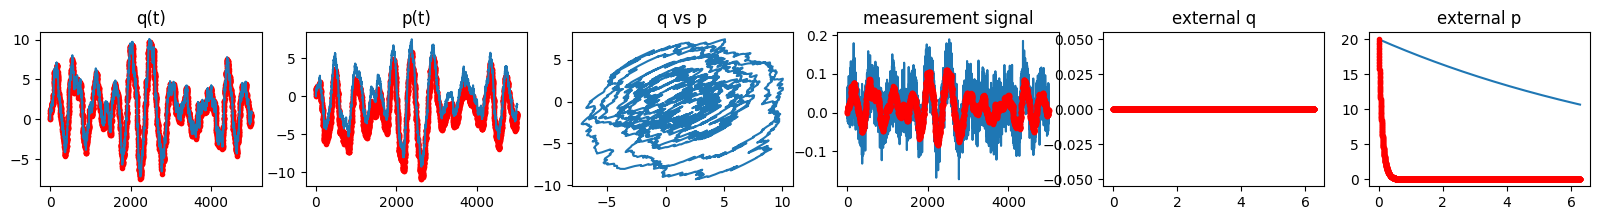

In [38]:
plt.figure(figsize=(20,2))
ax=plt.subplot(161)
ax.plot(xs_hat.detach().numpy()[:,0], color="red",marker='.')
ax.plot(x[:,0])

ax.set_title("q(t)")
ax=plt.subplot(162)
ax.plot(xs_hat.detach().numpy()[:,1], color="red",marker='.')
ax.plot(x[:,1])

ax.set_title("p(t)")

ax=plt.subplot(163)
ax.plot(x[:,0],x[:,1])
ax.set_title("q vs p")
ax=plt.subplot(164)
ax.plot(dy[:,0])
ax.plot(dys_hat.detach().numpy()[:,0], color="red",marker='.')

ax.set_title("measurement signal")
ax=plt.subplot(165)
ax.plot(times,f[:,0])
ax.plot(times,xs_hat.detach().numpy()[:-1,5], color="red",marker='.')

ax.set_title("external q")

ax=plt.subplot(166)
ax.set_title("external p")
ax.plot(times,f[:,1])
ax.plot(times,xs_hat.detach().numpy()[:-1,6], color="red",marker='.')





# Training

In [39]:
def log_lik(dys, dys_hat):
    return torch.sum((dys-dys_hat)**2)/(dt*len(dys))

In [40]:
def err_f(f,xs_hat):
    return np.sum(np.abs(f - xs_hat[:-1,5:7].detach().numpy() ))/np.sum(np.abs(f))

In [47]:
torch.manual_seed(0)
inputs_cell = [dt,  [gamma, omega, n, eta, kappa, b], [1.,[0., 20.]]]

x = load_data(itraj=1, what="hidden_state.npy")
dy = load_data(itraj=1,what="dys.npy")

dev = torch.device("cpu")
rrn = RecurrentNetwork(inputs_cell)


optimizer = torch.optim.Adam(list(rrn.parameters()), lr=1e-1)

dys = torch.tensor(data=dy, dtype=torch.float32).to(torch.device("cpu"))

history = {}
history["losses"] = []
history["params"] = [k.detach().numpy() for k in list(rrn.parameters())]
history["gradients"] = []

xs_hat, dys_hat = rrn(dys)
loss = log_lik(dys, dys_hat)
print(loss.item())
print(err_f(f,xs_hat))
print("\n")
history["losses"].append([loss.item(),err_f(f,xs_hat)] )

for ind in tqdm(range(40)):
    xs_hat, dys_hat = rrn(dys)
    loss = log_lik(dys, dys_hat)
    loss.backward()
    
    optimizer.step()
    history["losses"].append([loss.item(),err_f(f,xs_hat)] )
    history["params"].append([k.detach().numpy() for k in list(rrn.parameters())])
    history["gradients"].append([k.grad.numpy() for k in list(rrn.parameters())])
    
    print(loss.item())
    print(err_f(f,xs_hat))
    print("\n")
    optimizer.zero_grad()

1.0187244415283203
0.7859482681440494




  2%|██▊                                                                                                           | 1/40 [00:02<01:46,  2.74s/it]

1.0187244415283203
0.7859482681440494




  5%|█████▌                                                                                                        | 2/40 [00:05<01:39,  2.61s/it]

1.0182489156723022
0.7625684385492879




  8%|████████▎                                                                                                     | 3/40 [00:08<01:39,  2.69s/it]

1.0176790952682495
0.7337014001650087




 10%|███████████                                                                                                   | 4/40 [00:10<01:35,  2.64s/it]

1.0169880390167236
0.6973593279220198




 12%|█████████████▊                                                                                                | 5/40 [00:13<01:30,  2.60s/it]

1.016141414642334
0.6506237006501925




 15%|████████████████▌                                                                                             | 6/40 [00:15<01:27,  2.58s/it]

1.015097975730896
0.58912488666603




 18%|███████████████████▎                                                                                          | 7/40 [00:18<01:24,  2.56s/it]

1.013817548751831
0.506171649984284




 20%|██████████████████████                                                                                        | 8/40 [00:20<01:21,  2.56s/it]

1.0122898817062378
0.3912164157331404




 22%|████████████████████████▊                                                                                     | 9/40 [00:23<01:19,  2.55s/it]

1.0106291770935059
0.22696398394211004




 25%|███████████████████████████▎                                                                                 | 10/40 [00:25<01:16,  2.54s/it]

1.0093886852264404
0.01578691618913978




 28%|█████████████████████████████▉                                                                               | 11/40 [00:28<01:16,  2.62s/it]

1.0103809833526611
0.36281874410295434




 30%|████████████████████████████████▋                                                                            | 12/40 [00:31<01:12,  2.59s/it]

1.0115889310836792
0.48719167561185656




 32%|███████████████████████████████████▍                                                                         | 13/40 [00:33<01:09,  2.56s/it]

1.0106103420257568
0.39059603638258655




 35%|██████████████████████████████████████▏                                                                      | 14/40 [00:36<01:06,  2.55s/it]

1.0096032619476318
0.23149856669348856




 38%|████████████████████████████████████████▉                                                                    | 15/40 [00:38<01:03,  2.54s/it]

1.0093179941177368
0.08232523533273475




 40%|███████████████████████████████████████████▌                                                                 | 16/40 [00:41<01:00,  2.53s/it]

1.0095099210739136
0.031144757393042555




 42%|██████████████████████████████████████████████▎                                                              | 17/40 [00:44<01:00,  2.62s/it]

1.009831428527832
0.10766549709554844




 45%|█████████████████████████████████████████████████                                                            | 18/40 [00:46<00:58,  2.65s/it]

1.010095477104187
0.1534392364548293




 48%|███████████████████████████████████████████████████▊                                                         | 19/40 [00:49<00:57,  2.75s/it]

1.010235071182251
0.17453953306546421




 50%|██████████████████████████████████████████████████████▌                                                      | 20/40 [00:52<00:54,  2.71s/it]

1.010238766670227
0.17509050588142996




 52%|█████████████████████████████████████████████████████████▏                                                   | 21/40 [00:54<00:50,  2.68s/it]

1.0101207494735718
0.15736646934651854




 55%|███████████████████████████████████████████████████████████▉                                                 | 22/40 [00:57<00:47,  2.65s/it]

1.0099103450775146
0.12233374561767246




 57%|██████████████████████████████████████████████████████████████▋                                              | 23/40 [01:00<00:44,  2.62s/it]

1.0096558332443237
0.07038032238917098




 60%|█████████████████████████████████████████████████████████████████▍                                           | 24/40 [01:02<00:41,  2.61s/it]

1.0094289779663086
0.0024784759049092104




 62%|████████████████████████████████████████████████████████████████████▏                                        | 25/40 [01:05<00:38,  2.60s/it]

1.0093189477920532
0.07771607247225792




 65%|██████████████████████████████████████████████████████████████████████▊                                      | 26/40 [01:07<00:36,  2.59s/it]

1.009389877319336
0.16057321502913066




 68%|█████████████████████████████████████████████████████████████████████████▌                                   | 27/40 [01:10<00:34,  2.66s/it]

1.0095897912979126
0.2281006348580047




 70%|████████████████████████████████████████████████████████████████████████████▎                                | 28/40 [01:13<00:31,  2.65s/it]

1.0097264051437378
0.2593790596881659




 72%|███████████████████████████████████████████████████████████████████████████████                              | 29/40 [01:15<00:28,  2.62s/it]

1.0096629858016968
0.2456229689359696




 75%|█████████████████████████████████████████████████████████████████████████████████▊                           | 30/40 [01:18<00:26,  2.60s/it]

1.0094821453094482
0.19715403704092258




 78%|████████████████████████████████████████████████████████████████████████████████████▍                        | 31/40 [01:20<00:23,  2.59s/it]

1.0093458890914917
0.1335608159664354




 80%|███████████████████████████████████████████████████████████████████████████████████████▏                     | 32/40 [01:23<00:20,  2.59s/it]

1.0093210935592651
0.07186065555059437




 82%|█████████████████████████████████████████████████████████████████████████████████████████▉                   | 33/40 [01:26<00:18,  2.60s/it]

1.0093770027160645
0.0220528571704049




 85%|████████████████████████████████████████████████████████████████████████████████████████████▋                | 34/40 [01:29<00:16,  2.75s/it]

1.0094529390335083
0.011777654201883328




 88%|███████████████████████████████████████████████████████████████████████████████████████████████▍             | 35/40 [01:31<00:13,  2.68s/it]

1.00950288772583
0.0288994027023255




 90%|██████████████████████████████████████████████████████████████████████████████████████████████████           | 36/40 [01:34<00:10,  2.68s/it]

1.0095064640045166
0.030046069397511668




 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 37/40 [01:37<00:08,  2.72s/it]

1.0094661712646484
0.01655683835710661




 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 38/40 [01:40<00:05,  2.73s/it]

1.0094012022018433
0.009698061429087567




 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 39/40 [01:43<00:02,  2.83s/it]

1.0093419551849365
0.04585771174695855




100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [01:46<00:00,  2.67s/it]

1.0093175172805786
0.08732176799103744




In [50]:
ll = np.stack(history["losses"])

Text(0, 0.5, '$\\frac{\\sum_k |f_k - \\hat{f}_k|}{\\sum_k |f_k|}$')

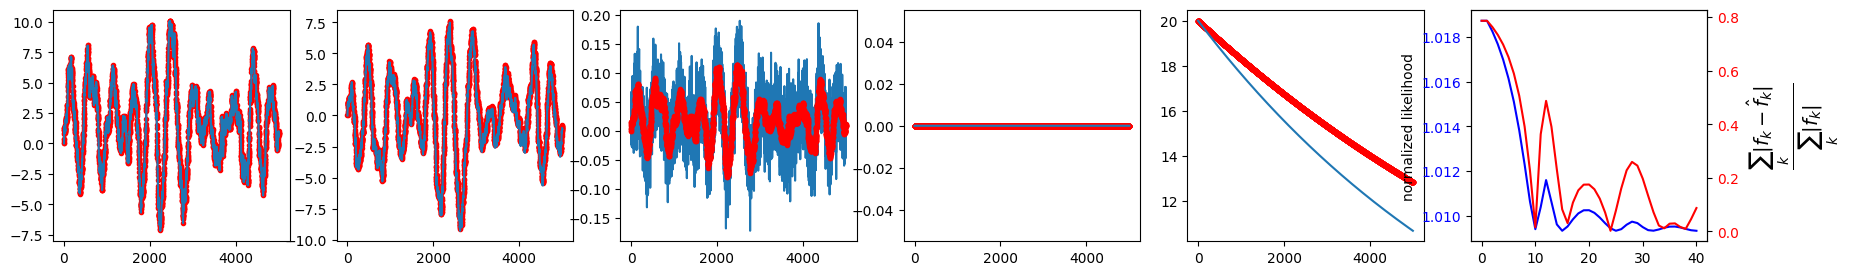

In [59]:
plt.figure(figsize=(25,3))
ax=plt.subplot(171)
ax.plot(xs_hat.detach().numpy()[:,0], color="red",marker='.')
ax.plot(x[:,0])
ax=plt.subplot(172)
ax.plot(xs_hat.detach().numpy()[:,1], color="red",marker='.')
ax.plot(x[:,1])
ax=plt.subplot(173)
ax.plot(dys[:,0])
ax.plot(dys_hat.detach().numpy()[:,0], color="red",marker='.')

ax=plt.subplot(174)
ax.plot(xs_hat.detach().numpy()[:,5], color="red",marker='.')
ax.plot(f[:,0])
ax=plt.subplot(175)
ax.plot(xs_hat.detach().numpy()[:,6], color="red",marker='.')
ax.plot(f[:,1])

ax=plt.subplot(176)
ax.plot(ll[:,0], color="blue")
ax.set_ylabel("normalized likelihood")
ax.tick_params(axis='y', labelcolor="blue")
ax = ax.twinx()
ax.plot(ll[:,1], color="red")
ax.tick_params(axis='y', labelcolor="red")
ax.set_ylabel(r'$\frac{\sum_k |f_k - \hat{f}_k|}{\sum_k |f_k|}$',size=20)

In [65]:
np.argmin(ll[:,1])

24

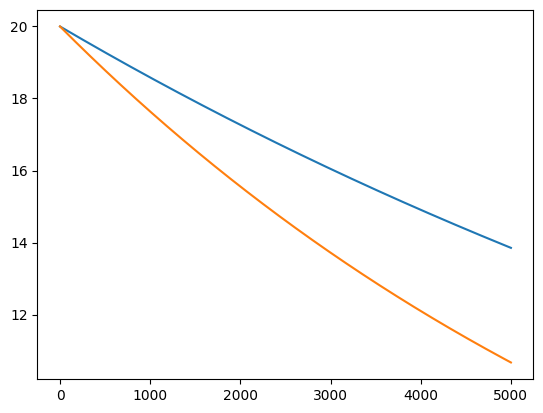

In [70]:
plt.plot(np.exp(-times*history["params"][np.argmin(ll[:,1])][0])*20.)
plt.plot(f[:,1])#np.exp(-times*history["params"][np.argmin(ll[:,1])][0])*20.)